In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# CLEANING

In [2]:
# Function to load and clean data
def load_and_clean_data(file_path):
    """Load a dataset and apply cleaning steps.
    Removes STD, season average, and last 5 matched sum
    Fills NULL/nan values with 0/zero
    and drops rows with more than 20% NULL values we cna change this
    I just felt like 20% seemed right"""
    try:
        df = pd.read_csv(file_path)
        #df = df.drop(df.filter(regex='_std$').columns, axis=1)

        # Drop rows where more than 80% of the data is missing
        threshold = int(0.20 * len(df.columns))  # Keep rows with at least 80% non-null values
        df = df.dropna(thresh=threshold)

        # Fill remaining missing values with zero
        df = df.fillna(0)
        return df
    except FileNotFoundError as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [3]:
def to_csv(df, file_path):
    """Save a DataFrame to a CSV file."""
    try:
        df.to_csv(file_path, index=False)
        print(f"Saved {file_path} ({df.shape[0]} rows, {df.shape[1]} columns)")
    except Exception as e:
        print(f"Error saving {file_path}: {e}")

In [4]:
# Define dataset paths
data_paths = {
    "train_home_team": "/content/Data/train_home_team_statistics_df.csv",
    "train_home_player": "/content/Data/train_home_player_statistics_df.csv" ,
    "train_away_team": "/content/Data/train_away_team_statistics_df.csv",
    "train_away_player": "/content/Data/train_away_player_statistics_df.csv",

    "test_home_team": "/content/Data/test_home_team_statistics_df.csv",
    "test_home_player": "/content/Data/test_home_player_statistics_df.csv",
    "test_away_team": "/content/Data/test_away_team_statistics_df.csv",
    "test_away_player": "/content/Data/test_away_player_statistics_df.csv"
}

In [5]:
train_home_team = load_and_clean_data(data_paths["train_home_team"])
#train_home_player = load_and_clean_data(data_paths["train_home_player"])
train_away_team = load_and_clean_data(data_paths["train_away_team"])
#train_away_player = load_and_clean_data(data_paths["train_away_player"])

test_home_team = load_and_clean_data(data_paths["test_home_team"])
#test_home_player = load_and_clean_data(data_paths["test_home_player"])
test_away_team = load_and_clean_data(data_paths["test_away_team"])
#test_away_player = load_and_clean_data(data_paths["test_away_player"])

print("Data cleaning completed.")

Data cleaning completed.


In [6]:
output_path = "/content/Data/CleanData"
os.makedirs(output_path, exist_ok=True)

to_csv(train_home_team, os.path.join(output_path, "train_home_team.csv"))
#to_csv(train_home_player, os.path.join(output_path, "train_home_player.csv"))
to_csv(train_away_team, os.path.join(output_path, "train_away_team.csv"))
#to_csv(train_away_player, os.path.join(output_path, "train_away_player.csv"))

to_csv(test_home_team, os.path.join(output_path, "test_home_team.csv"))
#to_csv(test_home_player, os.path.join(output_path, "test_home_player.csv"))
to_csv(test_away_team, os.path.join(output_path, "test_away_team.csv"))
#to_csv(test_away_player, os.path.join(output_path, "test_away_player.csv"))

print("Done")

Saved /content/Data/CleanData/train_home_team.csv (12303 rows, 143 columns)
Saved /content/Data/CleanData/train_away_team.csv (12303 rows, 143 columns)
Saved /content/Data/CleanData/test_home_team.csv (25368 rows, 141 columns)
Saved /content/Data/CleanData/test_away_team.csv (25368 rows, 141 columns)
Done


In [7]:
#Team data train and test
train_home_team = pd.read_csv("/content/Data/CleanData/train_home_team.csv")
train_away_team = pd.read_csv("/content/Data/CleanData/train_away_team.csv")

test_home_team = pd.read_csv("/content/Data/CleanData/test_home_team.csv")
test_away_team = pd.read_csv("/content/Data/CleanData/test_away_team.csv")


In [8]:
def rename_columns(columns):
    """
    Renames columns by removing 'TEAM_' prefix and '_season' substring.

    Args:
        columns (list): List of column names to be renamed.

    Returns:
        list: List of renamed column names.
    """
    renamed_columns = []
    for col in columns:
        # Remove 'TEAM_' prefix
        col = col.replace('TEAM_', '')
        # Remove '_season' substring
        col = col.replace('_season', '')
        # Change average to avg
        col = col.replace('average', 'avg')
        renamed_columns.append(col)
    return renamed_columns

In [9]:
# rename columns
train_home_team.columns = rename_columns(train_home_team.columns)
train_away_team.columns = rename_columns(train_away_team.columns)
test_home_team.columns = rename_columns(test_home_team.columns)
test_away_team.columns = rename_columns(test_away_team.columns)

# TESTING 1


In [10]:
features = [
    "SHOTS_ON_TARGET_avg", "ATTACKS_avg", "DANGEROUS_ATTACKS_avg",
    "BALL_POSSESSION_avg", "CORNERS_avg", "FOULS_avg"
]

In [11]:
# Prepare training data
X_train_home = train_home_team[features]
X_train_away = train_away_team[features]
y_train_home = train_home_team["GOALS_avg"]
y_train_away = train_away_team["GOALS_avg"]

In [12]:
# Add constant for Poisson regression
X_train_home = sm.add_constant(X_train_home)
X_train_away = sm.add_constant(X_train_away)

In [13]:
# Train Poisson regression models
poisson_home = sm.GLM(y_train_home, X_train_home, family=sm.families.Poisson()).fit()
poisson_away = sm.GLM(y_train_away, X_train_away, family=sm.families.Poisson()).fit()


In [14]:
# Prepare test data
X_test_home = sm.add_constant(test_home_team[features])
X_test_away = sm.add_constant(test_away_team[features])

In [15]:
# Predict expected goals
test_home_team["Expected_Goals"] = poisson_home.predict(X_test_home)
test_away_team["Expected_Goals"] = poisson_away.predict(X_test_away)

In [16]:
print(f"Train Home Max ID: {train_home_team['ID'].max()}, Test Home Min ID: {test_home_team['ID'].min()}")

Train Home Max ID: 12302, Test Home Min ID: 12303


In [17]:
print("Home")
print(test_home_team[["ID", "Expected_Goals"]].head())
print("Away")
print(test_away_team[["ID", "Expected_Goals"]].head())

Home
      ID  Expected_Goals
0  12303        2.076852
1  12304        2.288906
2  12305        6.592273
3  12306        6.210275
4  12307        2.197629
Away
      ID  Expected_Goals
0  12303        5.434353
1  12304        3.941672
2  12305        2.463659
3  12306        6.541262
4  12307        2.342042


In [18]:
print("Home")
print(poisson_home.summary())
print("Away")
print(poisson_away.summary())

Home
                 Generalized Linear Model Regression Results                  
Dep. Variable:              GOALS_avg   No. Observations:                12303
Model:                            GLM   Df Residuals:                    12296
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25171.
Date:                Thu, 06 Mar 2025   Deviance:                       16714.
Time:                        23:06:59   Pearson chi2:                 1.47e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6381
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    

# TESTING 2


In [23]:
df_train_team = train_home_team.merge(train_away_team, on="ID", suffixes=("_home", "_away"))

# Drop non-numeric columns
df_train_team = df_train_team.drop(columns=["NAME_home", "NAME_away", "LEAGUE_home", "LEAGUE_away"], errors="ignore")

# Define features and target
features = [col for col in df_train_team.columns if col not in ["ID", "GOALS_avg_home", "GOALS_avg_away"]]
X_train = df_train_team[features]
y_train_home = df_train_team["GOALS_avg_home"]
y_train_away = df_train_team["GOALS_avg_away"]

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# Train models
poisson_home = PoissonRegressor(alpha=0, max_iter=1000).fit(X_train_scaled, y_train_home)
poisson_away = PoissonRegressor(alpha=0, max_iter=1000).fit(X_train_scaled, y_train_away)

In [25]:
# Merge test datasets
df_test = test_home_team.merge(test_away_team, on="ID", suffixes=("_home", "_away"))

# Drop non-numeric columns
df_test = df_test.drop(columns=["NAME_home", "NAME_away", "LEAGUE_home", "LEAGUE_away"], errors="ignore")

# Select features
X_test = df_test[features]
X_test_scaled = scaler.transform(X_test)  # Scale test data

# Predict Expected Goals
df_test["Expected_Goals_home"] = poisson_home.predict(X_test_scaled)
df_test["Expected_Goals_away"] = poisson_away.predict(X_test_scaled)

In [26]:
# Define predicted match result
df_test["Predicted_Result"] = df_test.apply(
    lambda row: "Home Win" if row["Expected_Goals_home"] > row["Expected_Goals_away"]
    else "Away Win" if row["Expected_Goals_home"] < row["Expected_Goals_away"]
    else "Draw", axis=1
)

# Count occurrences of each outcome
print(df_test["Predicted_Result"].value_counts())

Predicted_Result
Away Win    12922
Home Win    12446
Name: count, dtype: int64


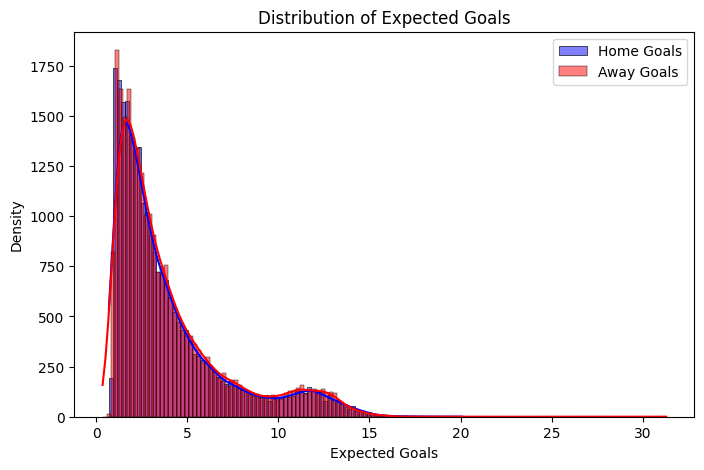

In [27]:
plt.figure(figsize=(8, 5))
sns.histplot(df_test["Expected_Goals_home"], color="blue", label="Home Goals", kde=True)
sns.histplot(df_test["Expected_Goals_away"], color="red", label="Away Goals", kde=True)
plt.title("Distribution of Expected Goals")
plt.xlabel("Expected Goals")
plt.ylabel("Density")
plt.legend()
plt.show()

# TESTING 3


In [28]:
# Merge home and away data for training
train_data = pd.merge(train_home_team, train_away_team, on='ID', suffixes=('_home', '_away'))

# Merge home and away data for testing
test_data = pd.merge(test_home_team, test_away_team, on='ID', suffixes=('_home', '_away'))

In [29]:
# Features for home team goals
home_features = [
    'GOALS_avg_home', 'SHOTS_ON_TARGET_avg_home', 'PASSES_avg_home',
    'DANGEROUS_ATTACKS_avg_home', 'GOALS_std_home'
]

# Features for away team goals
away_features = [
    'GOALS_avg_away', 'SHOTS_ON_TARGET_avg_away', 'PASSES_avg_away',
    'DANGEROUS_ATTACKS_avg_away', 'GOALS_std_away'
]

# Define training data for home and away teams
X_train_home = train_data[home_features]
X_train_away = train_data[away_features]

# Define targets (goals scored by home and away teams)
y_train_home = train_data['GOALS_sum_home']
y_train_away = train_data['GOALS_sum_away']

In [30]:
# Add intercept for Poisson regression
X_train_home = sm.add_constant(X_train_home)
X_train_away = sm.add_constant(X_train_away)

# Train Poisson model for home team
poisson_model_home = sm.Poisson(y_train_home, X_train_home).fit()

# Train Poisson model for away team
poisson_model_away = sm.Poisson(y_train_away, X_train_away).fit()

# Print model summaries
print(poisson_model_home.summary())
print(poisson_model_away.summary())

Optimization terminated successfully.
         Current function value: 1.691809
         Iterations 6
Optimization terminated successfully.
         Current function value: 1.697478
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:         GOALS_sum_home   No. Observations:                12303
Model:                        Poisson   Df Residuals:                    12297
Method:                           MLE   Df Model:                            5
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                  0.3450
Time:                        23:19:12   Log-Likelihood:                -20814.
converged:                       True   LL-Null:                       -31779.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [31]:
# Define test data for home and away teams
X_test_home = test_data[home_features]
X_test_away = test_data[away_features]

# Add intercept for Poisson regression
X_test_home = sm.add_constant(X_test_home)
X_test_away = sm.add_constant(X_test_away)

# Predict goals for home and away teams
test_data['PREDICTED_GOALS_HOME'] = poisson_model_home.predict(X_test_home)
test_data['PREDICTED_GOALS_AWAY'] = poisson_model_away.predict(X_test_away)


In [32]:
# Determine match outcome based on predicted goals
test_data['PREDICTED_OUTCOME'] = 'Draw'
test_data.loc[test_data['PREDICTED_GOALS_HOME'] > test_data['PREDICTED_GOALS_AWAY'], 'PREDICTED_OUTCOME'] = 'Home Win'
test_data.loc[test_data['PREDICTED_GOALS_HOME'] < test_data['PREDICTED_GOALS_AWAY'], 'PREDICTED_OUTCOME'] = 'Away Win'

# Display results
print(test_data[['ID', 'PREDICTED_GOALS_HOME', 'PREDICTED_GOALS_AWAY', 'PREDICTED_OUTCOME']])

          ID  PREDICTED_GOALS_HOME  PREDICTED_GOALS_AWAY PREDICTED_OUTCOME
0      12303              1.355759              2.826835          Away Win
1      12304              2.221885              6.592441          Away Win
2      12305             13.334265              2.789839          Home Win
3      12306              6.635421              6.509784          Home Win
4      12307              2.691767              1.421433          Home Win
...      ...                   ...                   ...               ...
25363  37666              3.468327              6.620185          Away Win
25364  37667              4.413604             10.025950          Away Win
25365  37668              8.536310              4.279897          Home Win
25366  37669              2.702990              3.381518          Away Win
25367  37670              2.192328              2.152613          Home Win

[25368 rows x 4 columns]


In [33]:
# Predict outcomes based on average goals
test_data['PREDICTED_OUTCOME'] = 'Draw'
test_data.loc[test_data['GOALS_avg_home'] > test_data['GOALS_avg_away'], 'PREDICTED_OUTCOME'] = 'Home Win'
test_data.loc[test_data['GOALS_avg_home'] < test_data['GOALS_avg_away'], 'PREDICTED_OUTCOME'] = 'Away Win'

# Display results
print(test_data[['ID', 'GOALS_avg_home', 'GOALS_avg_away', 'PREDICTED_OUTCOME']])

          ID  GOALS_avg_home  GOALS_avg_away PREDICTED_OUTCOME
0      12303             0.0             3.0          Away Win
1      12304             2.0             7.0          Away Win
2      12305            10.0             3.0          Home Win
3      12306             7.0             7.0              Draw
4      12307             3.0             0.0          Home Win
...      ...             ...             ...               ...
25363  37666             4.0             7.0          Away Win
25364  37667             5.0             9.0          Away Win
25365  37668             8.0             5.0          Home Win
25366  37669             3.0             4.0          Away Win
25367  37670             2.0             2.0              Draw

[25368 rows x 4 columns]


# Graphing